# xRFI explorative tests

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

from edges_cal import xrfi

In [2]:
NFREQ = 1000
freq = np.linspace(50, 150, NFREQ)

In [3]:
p = np.poly1d([1750, 0, 3, -2, 7, 5][::-1])
f = np.linspace(-1, 1, len(freq))
sky_model = (freq / 75.0) ** -2.55 * p(f)

In [4]:
rfi_model = np.zeros(NFREQ)
# rfi_model[::50] = 1

In [5]:
def thermal_noise(spec, scale=1, seed=None):
    if seed:
        np.random.seed(seed)
    return np.random.normal(0, spec / scale)

In [6]:
scale = 1000
amplitude = 50

In [7]:
std = sky_model / scale
amp = std.max() * amplitude
noise = thermal_noise(sky_model, scale=scale, seed=1010)
rfi = rfi_model * amp
sky = sky_model + noise + rfi

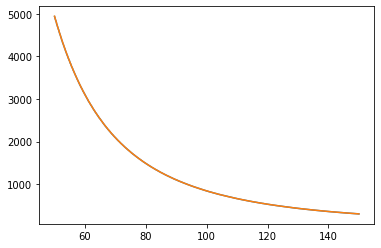

In [8]:
plt.plot(freq, sky)
plt.plot(freq, sky_model)

In [9]:
sig = xrfi.detrend_medfilt(sky, half_size=(8,))

In [84]:
f = np.linspace(0, 1, len(sky))
resid = sky - xrfi.ModelFit("polynomial", f, sky, n_terms=3).evaluate()

Polynomial


<IPython.core.display.Javascript object>


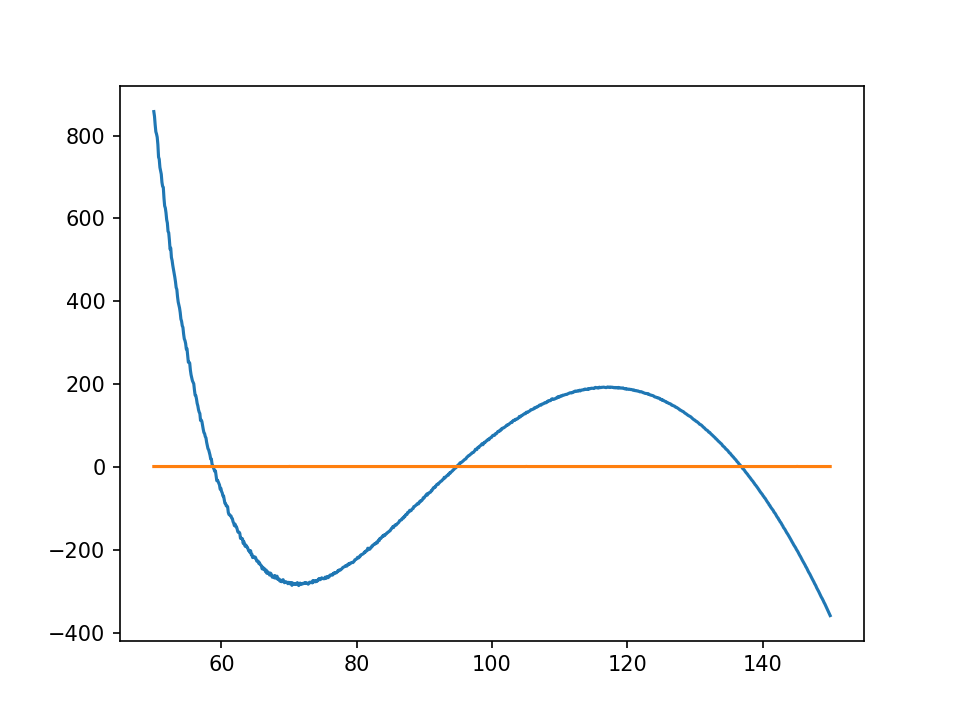

In [85]:
plt.plot(freq, resid)

In [86]:
size = 5
d_sm = xrfi.flagged_median_filter(resid, size=(size,))
d_rs = sky - d_sm
d_sq = d_rs ** 2
sigma = np.sqrt(xrfi.flagged_median_filter(d_sq, size=(size,)) / 0.456)
significance = xrfi.robust_divide(d_rs, sigma)
flags = np.abs(significance) > 10

<IPython.core.display.Javascript object>


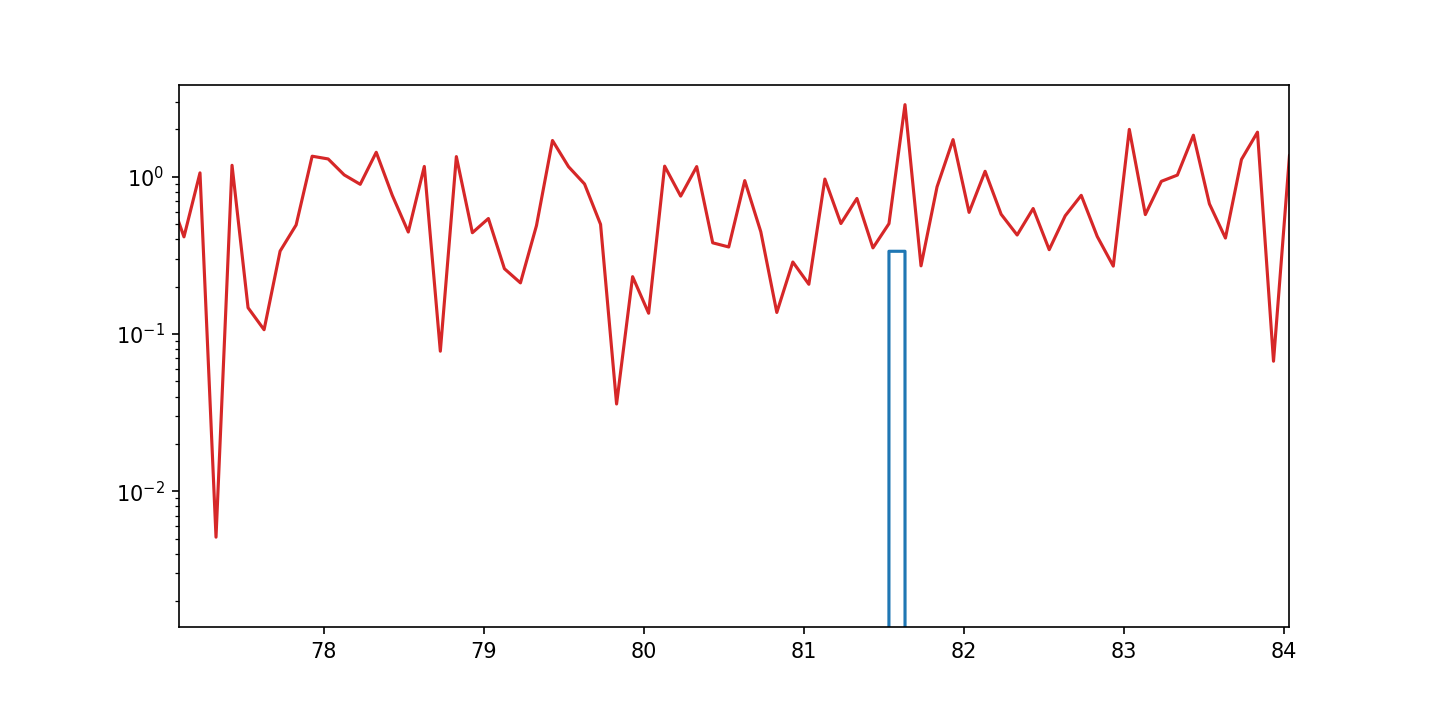

In [67]:
plt.plot(freq, np.abs(d_rs))
plt.plot(freq, sigma)
plt.plot(freq, significance)
plt.plot(freq, np.abs(sky - sky_model) / std)
plt.yscale("log")

In [87]:
np.any(flags), np.where(flags)[0]

(False, array([], dtype=int64))

In [72]:
d_rs[313:319]

array([ 0.        ,  0.        , -0.33549046,  0.33549046,  0.        ,
        0.        ])

In [64]:
flags, sig = xrfi.xrfi_medfilt(sky, kf=1)

(3,)


In [65]:
np.any(flags)

False

In [21]:
np.where(flags)

(array([  0,   1,   2,   3, 315, 316, 374, 375, 512, 513, 549, 550, 586,
        587, 595, 596, 641, 642, 651, 652, 657, 658, 685, 686, 697, 698,
        730, 731, 743, 744, 751, 752, 757, 758, 765, 766, 771, 772, 801,
        802, 820, 821, 845, 846, 850, 851, 870, 871, 900, 901, 902, 903,
        909, 910, 916, 918, 921, 922, 923, 924, 925, 926, 935, 936, 963,
        964, 967, 968, 976, 977, 986, 987, 990, 991, 992, 993, 994, 995,
        997, 998, 999]),)

### Uniform spectrum, regular RFI

In [10]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
rfi_model[50::50] = 1

rfi = rfi_model * 0.2
noise = thermal_noise(sky_model, scale=1000)
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [121]:
spectrum = sky
kf = 5
max_iter = 1
use_meanfilt = True
poly_order = 0
inplace = False
flags = None
threshold = 6
accumulate = False

# ------
iter = 0

if flags is None:
    new_flags = np.zeros(spectrum.shape, dtype=bool)
else:
    new_flags = flags if inplace else flags.copy()

nflags = -1

resid = spectrum.copy()

size = (kf,) if spectrum.ndim == 1 else (kt, kf)
while iter < max_iter and np.sum(new_flags) > nflags:
    nflags = np.sum(new_flags)

    if spectrum.ndim == 1 and poly_order:
        f = np.linspace(0, 1, len(spectrum))
        resid[~new_flags] = (
            spectrum[~new_flags]
            - ModelFit(
                "polynomial",
                f[~new_flags],
                spectrum[~new_flags],
                n_terms=poly_order,
            ).evaluate()
        )
    else:
        resid = spectrum

    significance_med = xrfi.detrend_medfilt(resid, half_size=size, flags=new_flags)
    medfilt_flags = np.abs(significance_med) > threshold

    if use_meanfilt:
        significance = xrfi.detrend_meanfilt(resid, half_size=size, flags=medfilt_flags)

    if accumulate:
        new_flags |= np.abs(significance) > threshold
    else:
        new_flags = np.abs(significance) > threshold

    iter += 1

if 1 < max_iter == iter and np.sum(new_flags) > nflags:
    warnings.warn("Median filter reached max_iter and is still finding new RFI.")

In [122]:
data = resid

# --------------

# Meanfilt function

full_size = tuple(2 * s + 1 for s in size)

d_sm = xrfi.flagged_filter(data, size=full_size, kind="mean", flags=medfilt_flags)
d_rs = data - d_sm
d_sq = d_rs ** 2

# Factor of .456 is to put mod-z scores on same scale as standard deviation.
sig = np.sqrt(xrfi.flagged_filter(d_sq, size=full_size, kind="mean", flags=medfilt_flags))

# don't divide by zero, instead turn those entries into +inf
mean_sig = xrfi.robust_divide(d_rs, sig)

In [127]:
print("False positives: ", np.sum(medfilt_flags[~flags]))
print("False negatives: ", np.sum(~medfilt_flags[flags]))

False positives:  6
False negatives:  0


<IPython.core.display.Javascript object>


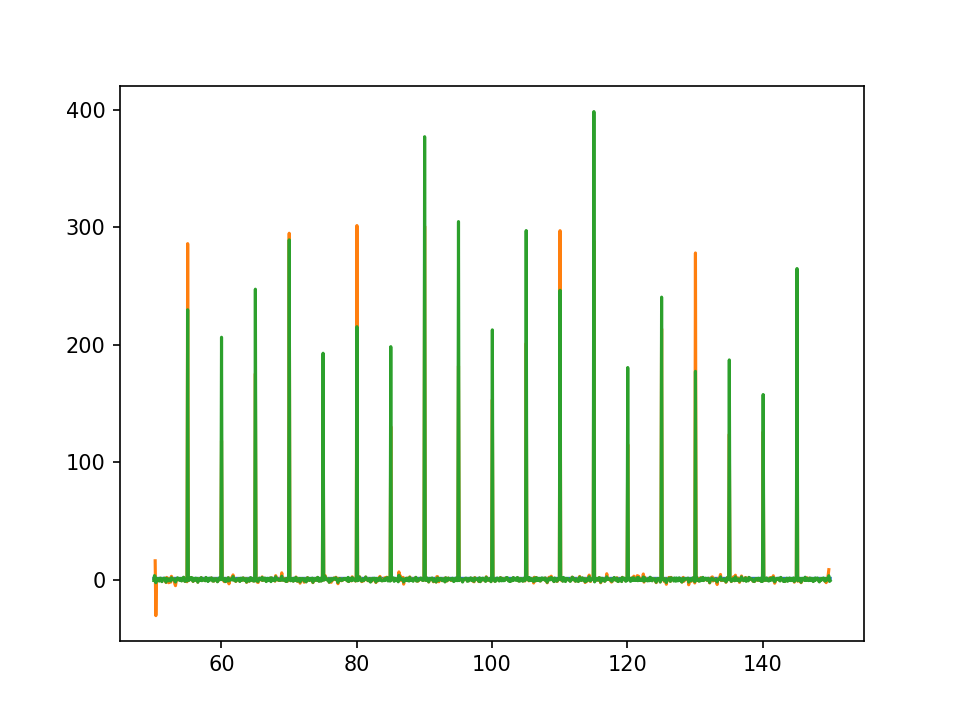

In [128]:
plt.plot(freq, sky)
plt.plot(freq, significance_med)
plt.plot(freq, significance)

In [131]:
print("False positives after medfilt: ", np.sum(medfilt_flags[~true_flags]))
print("False negatives after medfilt: ", np.sum(~medfilt_flags[true_flags]))
print("False positives after meanfilt: ", np.sum(new_flags[~true_flags]))
print("False negatives after meanfilt: ", np.sum(~new_flags[true_flags]))


False positives after medfilt:  6
False negatives after medfilt:  0
False positives after meanfilt:  0
False negatives after meanfilt:  0


## Poly

### Flat sky

In [156]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
rfi_model[50::50] = 1

rfi = rfi_model * 0.2
noise = thermal_noise(sky_model, scale=1000)
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [165]:
spectrum = sky
weights = None
f_ratio = None
f_log = False
t_log = True,
n_signal = None
n_resid = 3
n_abs_resid_threshold = 5
max_iter = 4
accumulate = False

# ------------

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert n_abs_resid_threshold > 1.5


nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if n_signal is None:
    n_signal = 2
    do_increase = True
else:
    do_increase = False
    assert n_resid < n_signal

n_flags = np.sum(flags)
n_flags_new = n_flags + 1
counter = 0
while (
    n_flags < n_flags_new
    and counter < max_iter
    and (nf - n_flags_new) > n_signal * 2
):
    n_flags = 1 * n_flags_new

    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)
        s = np.exp(s)

    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        flags[~flags] |= np.abs(res)[~flags] > n_abs_resid_threshold * model_std[~flags]
    else:
        flags = orig_flags | (np.abs(res) > n_abs_resid_threshold * model_std)

    print(f"False positives after {counter + 1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter + 1} iters: ", np.sum(~flags[true_flags]))

    n_flags_new = np.sum(flags)
    counter += 1
    if do_increase:
        n_signal += 1



False positives after 1 iters:  0
False negatives after 1 iters:  0
False positives after 2 iters:  0
False negatives after 2 iters:  0


### PL Sky

In [166]:
def sky_pl_1d(freq):
    return 1750 * (freq / 75.0) ** -2.55



In [194]:
sky_model = sky_pl_1d(freq)
rfi_model = np.zeros(NFREQ)
# rfi_model[50::50] = 1


noise = thermal_noise(sky_model, scale=1000)
rfi = rfi_model * (sky_model / 1000).max() * 200
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

<IPython.core.display.Javascript object>


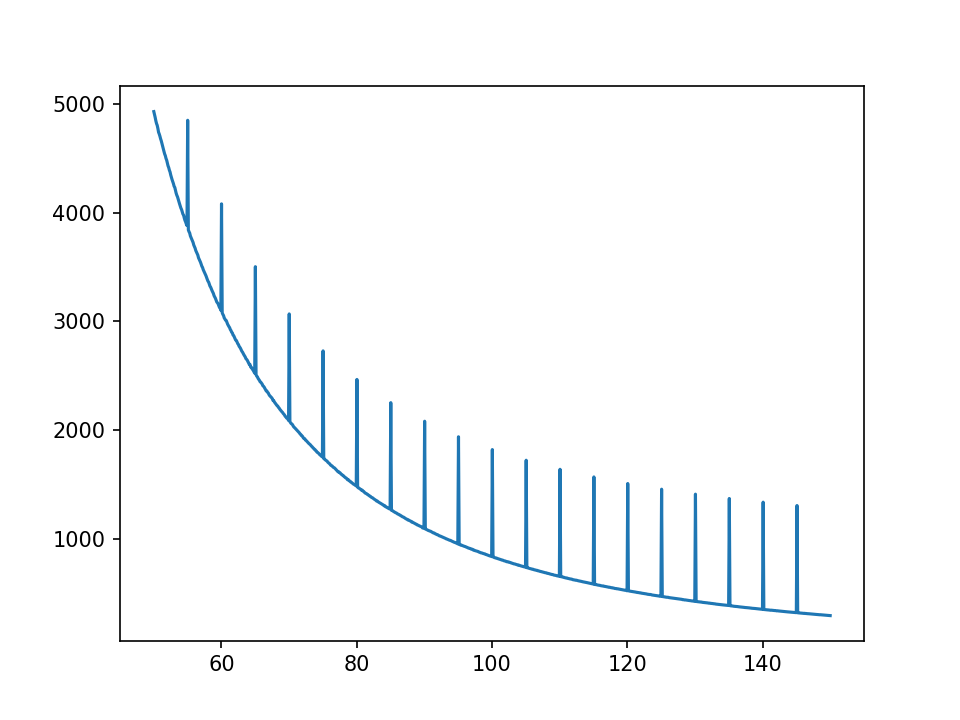

In [171]:
plt.plot(freq, sky)

In [201]:
spectrum = sky
weights = None
f_ratio = None
f_log = False
t_log = True,
n_signal = 2
n_resid = 3
n_abs_resid_threshold = 10
max_iter = 20
accumulate = False
do_increase = True

# ------------

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert n_abs_resid_threshold > 1.5


nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if not do_increase:
    assert n_resid < n_signal

n_flags_changed = 1
counter = 0
while (
    n_flags_changed > 0
    and counter < max_iter
    and np.sum(~flags) > n_signal * 2
):
    n_flags = 1 * n_flags_new

    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)
        s = np.exp(s)

    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        nflags = np.sum(flags[~flags])
        flags[~flags] |= np.abs(res)[~flags] > n_abs_resid_threshold * model_std[~flags]
        n_flags_changed = np.sum(flags[~flags]) - nflags
    else:

        new_flags = orig_flags | (np.abs(res) > n_abs_resid_threshold * model_std)
        n_flags_changed = np.sum(flags ^ new_flags)
        flags = new_flags.copy()

    print(f"False positives after {counter + 1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter + 1} iters: ", np.sum(~flags[true_flags]))

    counter += 1
    if do_increase:
        n_signal += 1

False positives after 1 iters:  51
False negatives after 1 iters:  0
False positives after 2 iters:  91
False negatives after 2 iters:  0
False positives after 3 iters:  111
False negatives after 3 iters:  0
False positives after 4 iters:  74
False negatives after 4 iters:  0
False positives after 5 iters:  43
False negatives after 5 iters:  0
False positives after 6 iters:  27
False negatives after 6 iters:  0
False positives after 7 iters:  13
False negatives after 7 iters:  0
False positives after 8 iters:  1
False negatives after 8 iters:  0
False positives after 9 iters:  0
False negatives after 9 iters:  0
False positives after 10 iters:  0
False negatives after 10 iters:  0


<IPython.core.display.Javascript object>


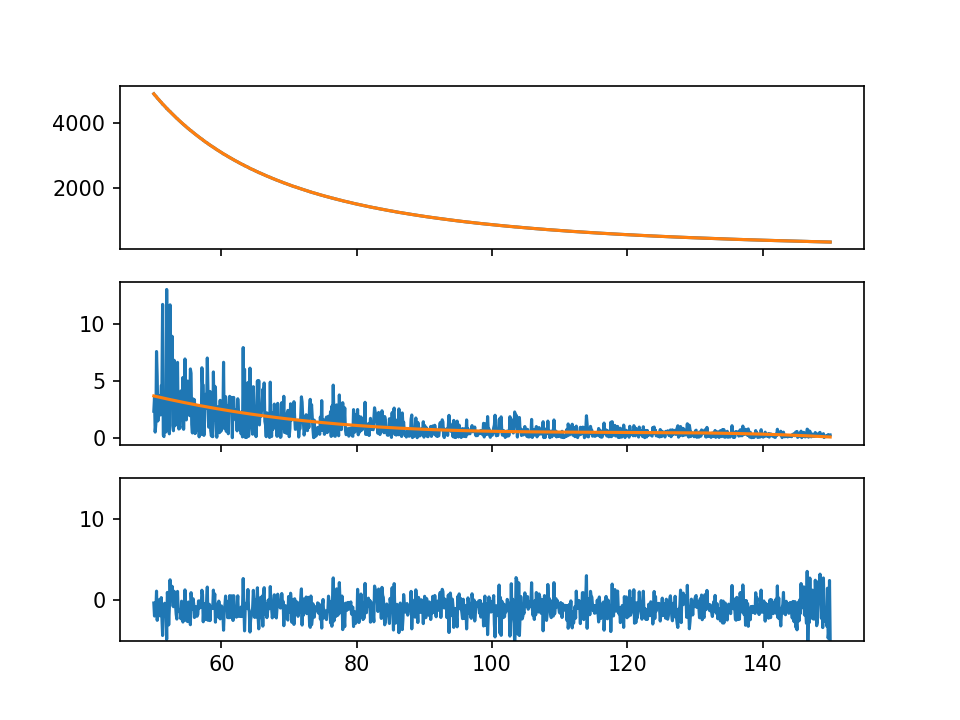

(-5, 15)

In [202]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(freq, sky)
ax[0].plot(freq, model)

ax[1].plot(freq, np.abs(res))
ax[1].plot(freq, model_std)

ax[2].plot(freq, res / model_std - 1)
ax[2].set_ylim((-5, 15))

### Flat / random

In [212]:
sky_model = np.ones(NFREQ)
rfi_model = np.zeros(NFREQ)
np.random.seed(12345)
rfi_model[np.random.randint(0, NFREQ, 40)] = 1

noise = thermal_noise(sky_model, scale=1000)
rfi = rfi_model * (sky_model / 1000).max() * 200
sky = rfi + noise + sky_model
true_flags = rfi_model > 0

In [213]:
spectrum = sky
weights = None
f_ratio = None
f_log = False
t_log = True,
n_signal = 2
n_resid = 3
threshold = 10
max_iter = 20
accumulate = False
increase_order = True
min_threshold = 5
decrement_threshold = 0
# ------------

if min_threshold > threshold:
    warnings.warn(f"You've set a threshold smaller than the min_threshold of {min_threshold}. Will use threshold={min_threshold}.")
    threshold = min_threshold

if f_log and not f_ratio:
    raise ValueError("If fitting in log(freq), you must provide f_ratio.")

assert threshold > 3

nf = spectrum.shape[-1]
orig_flags = np.zeros(nf, dtype=bool)
f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)

orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

if weights is not None:
    orig_flags |= weights <= 0

flags = orig_flags.copy()

if not increase_order:
    assert n_resid < n_signal

n_flags_changed = 1
counter = 0

while (
    n_flags_changed > 0
    and counter < max_iter
    and np.sum(~flags) > n_signal * 2
):
    ff = f[~flags]
    s = spectrum[~flags]

    if t_log:
        s = np.log(s)

    par = np.polyfit(ff, s, n_signal)
    model = np.polyval(par, f)

    if t_log:
        model = np.exp(model)

    res = spectrum - model

    par = np.polyfit(ff, np.abs(res[~flags]), n_resid if n_resid > 0 else n_signal + n_resid)
    model_std = np.polyval(par, f)

    if accumulate:
        nflags = np.sum(flags[~flags])
        flags[~flags] |= np.abs(res)[~flags] > threshold * model_std[~flags]
        n_flags_changed = np.sum(flags[~flags]) - nflags
    else:
        new_flags = orig_flags | (np.abs(res) > threshold * model_std)
        n_flags_changed = np.sum(flags ^ new_flags)
        flags = new_flags.copy()

    counter += 1
    if increase_order:
        n_signal += 1

    threshold = max(threshold - decrement_threshold, min_threshold)

    print(f"False positives after {counter + 1} iters: ", np.sum(flags[~true_flags]))
    print(f"False negatives after {counter + 1} iters: ", np.sum(~flags[true_flags]))


False positives after 2 iters:  0
False negatives after 2 iters:  11
False positives after 3 iters:  97
False negatives after 3 iters:  3
False positives after 4 iters:  289
False negatives after 4 iters:  0
False positives after 5 iters:  0
False negatives after 5 iters:  0
False positives after 6 iters:  0
False negatives after 6 iters:  0


<IPython.core.display.Javascript object>


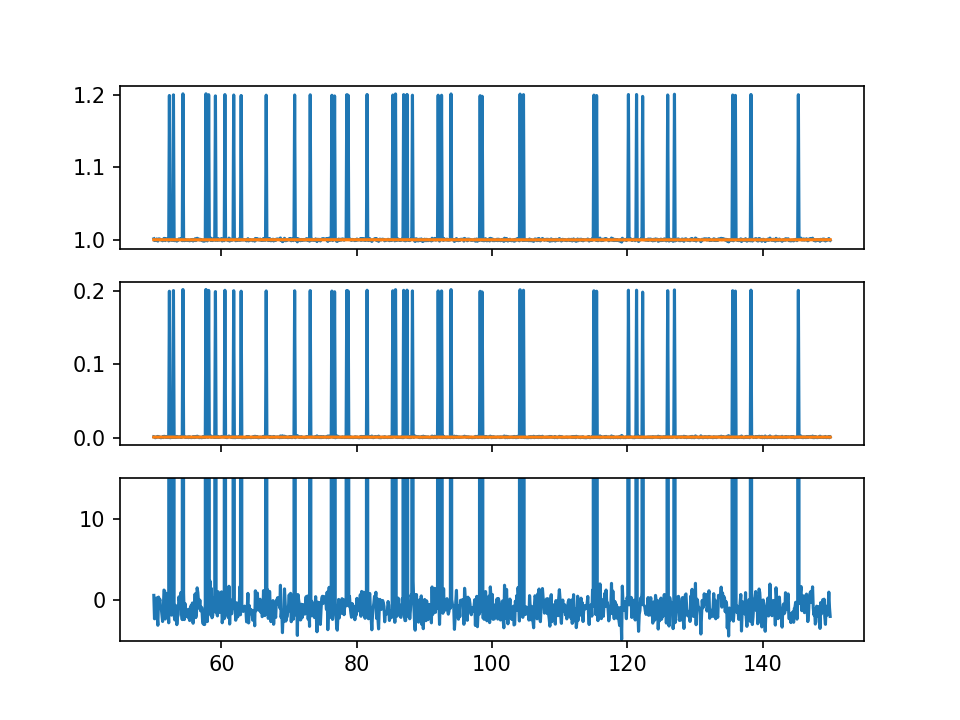

(-5, 15)

In [214]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(freq, sky)
ax[0].plot(freq, model)

ax[1].plot(freq, np.abs(res))
ax[1].plot(freq, model_std)

ax[2].plot(freq, res / model_std - 1)
ax[2].set_ylim((-5, 15))

## Flat Sky, Regular RFI, Poly Sweep

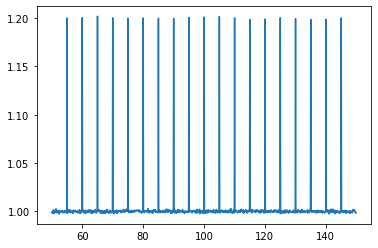

In [3]:
uniform_sky = np.ones(NFREQ)


def thermal_noise(spec, scale=1, seed=None):
    if seed:
        np.random.seed(seed)
    return np.random.normal(0, spec / scale)


def rfi_regular_1d():
    a = np.zeros(NFREQ)
    a[50::50] = 1
    return a


scale = 1000
std = uniform_sky / scale
amp = std.max() * 200
noise = thermal_noise(uniform_sky, scale=scale, seed=1010)
rfi = rfi_regular_1d() * amp
sky = uniform_sky + noise + rfi

plt.plot(freq, sky)

In [4]:
from edges_cal import xrfi

In [34]:
flags, info = xrfi.xrfi_model_sweep(sky, threshold=5)

windowmax 99
maxd:  1.2001267598264984
n_flags_changed:  1
true flags now (0 -- 99): [50]
windowmax 100
maxd:  1.200442802200185
n_flags_changed:  1
true flags now (1 -- 100): [ 50 100]
99 2 True True True 2
windowmax 101
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (2 -- 101): [ 50 100]
99 2 True False False 2
windowmax 102
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (3 -- 102): [ 50 100]
99 2 True False False 2
windowmax 103
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (4 -- 103): [ 50 100]
99 2 True False False 2
windowmax 104
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (5 -- 104): [ 50 100]
99 2 True False False 2
windowmax 105
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (6 -- 105): [ 50 100]
99 2 True False False 2
windowmax 106
maxd:  1.200442802200185
n_flags_changed:  0
true flags now (7 -- 106): [ 50 100]
99 2 True False False 2
windowmax 107
maxd:  1.200442802200185
n_flags_changed:  0
true flags no

n_flags_changed:  0
true flags now (70 -- 169): [100 150]
99 2 True False False 2
windowmax 170
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (71 -- 170): [100 150]
99 2 True False False 2
windowmax 171
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (72 -- 171): [100 150]
99 2 True False False 2
windowmax 172
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (73 -- 172): [100 150]
99 2 True False False 2
windowmax 173
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (74 -- 173): [100 150]
99 2 True False False 2
windowmax 174
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (75 -- 174): [100 150]
99 2 True False False 2
windowmax 175
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (76 -- 175): [100 150]
99 2 True False False 2
windowmax 176
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (77 -- 176): [100 150]
99 2 True False False 2
windowmax 177
maxd:  1.2019874340941064
n_flags_changed:  0
true

n_flags_changed:  0
true flags now (144 -- 243): [150 200]
99 2 True False False 2
windowmax 244
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (145 -- 244): [150 200]
99 2 True False False 2
windowmax 245
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (146 -- 245): [150 200]
99 2 True False False 2
windowmax 246
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (147 -- 246): [150 200]
99 2 True False False 2
windowmax 247
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (148 -- 247): [150 200]
99 2 True False False 2
windowmax 248
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (149 -- 248): [150 200]
99 2 True False False 2
windowmax 249
maxd:  1.2019874340941064
n_flags_changed:  0
true flags now (150 -- 249): [150 200]
99 2 True False False 2
windowmax 250
maxd:  1.2002517860347246
n_flags_changed:  1
true flags now (151 -- 250): [200 250]
99 2 True True True 2
windowmax 251
maxd:  1.2002517860347246
n_flags_changed:  

n_flags_changed:  0
true flags now (221 -- 320): [250 300]
99 2 True False False 2
windowmax 321
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (222 -- 321): [250 300]
99 2 True False False 2
windowmax 322
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (223 -- 322): [250 300]
99 2 True False False 2
windowmax 323
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (224 -- 323): [250 300]
99 2 True False False 2
windowmax 324
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (225 -- 324): [250 300]
99 2 True False False 2
windowmax 325
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (226 -- 325): [250 300]
99 2 True False False 2
windowmax 326
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (227 -- 326): [250 300]
99 2 True False False 2
windowmax 327
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (228 -- 327): [250 300]
99 2 True False False 2
windowmax 328
maxd:  1.200135424597986
n_flags_changed:  0
true

n_flags_changed:  0
true flags now (294 -- 393): [300 350]
99 2 True False False 2
windowmax 394
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (295 -- 394): [300 350]
99 2 True False False 2
windowmax 395
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (296 -- 395): [300 350]
99 2 True False False 2
windowmax 396
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (297 -- 396): [300 350]
99 2 True False False 2
windowmax 397
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (298 -- 397): [300 350]
99 2 True False False 2
windowmax 398
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (299 -- 398): [300 350]
99 2 True False False 2
windowmax 399
maxd:  1.200135424597986
n_flags_changed:  0
true flags now (300 -- 399): [300 350]
99 2 True False False 2
windowmax 400
maxd:  1.199888861023436
n_flags_changed:  1
true flags now (301 -- 400): [350 400]
99 2 True True True 2
windowmax 401
maxd:  1.199888861023436
n_flags_changed:  0
true f

n_flags_changed:  0
true flags now (368 -- 467): [400 450]
99 2 True False False 2
windowmax 468
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (369 -- 468): [400 450]
99 2 True False False 2
windowmax 469
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (370 -- 469): [400 450]
99 2 True False False 2
windowmax 470
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (371 -- 470): [400 450]
99 2 True False False 2
windowmax 471
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (372 -- 471): [400 450]
99 2 True False False 2
windowmax 472
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (373 -- 472): [400 450]
99 2 True False False 2
windowmax 473
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (374 -- 473): [400 450]
99 2 True False False 2
windowmax 474
maxd:  1.200742765476311
n_flags_changed:  0
true flags now (375 -- 474): [400 450]
99 2 True False False 2
windowmax 475
maxd:  1.200742765476311
n_flags_changed:  0
true

n_flags_changed:  0
true flags now (480 -- 579): [500 550]
99 2 True False False 2
windowmax 580
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (481 -- 580): [500 550]
99 2 True False False 2
windowmax 581
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (482 -- 581): [500 550]
99 2 True False False 2
windowmax 582
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (483 -- 582): [500 550]
99 2 True False False 2
windowmax 583
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (484 -- 583): [500 550]
99 2 True False False 2
windowmax 584
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (485 -- 584): [500 550]
99 2 True False False 2
windowmax 585
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (486 -- 585): [500 550]
99 2 True False False 2
windowmax 586
maxd:  1.20171380298948
n_flags_changed:  0
true flags now (487 -- 586): [500 550]
99 2 True False False 2
windowmax 587
maxd:  1.20171380298948
n_flags_changed:  0
true flags n

n_flags_changed:  0
true flags now (553 -- 652): [600 650]
99 2 True False False 2
windowmax 653
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (554 -- 653): [600 650]
99 2 True False False 2
windowmax 654
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (555 -- 654): [600 650]
99 2 True False False 2
windowmax 655
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (556 -- 655): [600 650]
99 2 True False False 2
windowmax 656
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (557 -- 656): [600 650]
99 2 True False False 2
windowmax 657
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (558 -- 657): [600 650]
99 2 True False False 2
windowmax 658
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (559 -- 658): [600 650]
99 2 True False False 2
windowmax 659
maxd:  1.2002535424979632
n_flags_changed:  0
true flags now (560 -- 659): [600 650]
99 2 True False False 2
windowmax 660
maxd:  1.2002535424979632
n_flags_changed:

windowmax 731
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (632 -- 731): [650 700]
99 2 True False False 2
windowmax 732
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (633 -- 732): [650 700]
99 2 True False False 2
windowmax 733
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (634 -- 733): [650 700]
99 2 True False False 2
windowmax 734
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (635 -- 734): [650 700]
99 2 True False False 2
windowmax 735
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (636 -- 735): [650 700]
99 2 True False False 2
windowmax 736
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (637 -- 736): [650 700]
99 2 True False False 2
windowmax 737
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (638 -- 737): [650 700]
99 2 True False False 2
windowmax 738
maxd:  1.1991626073688335
n_flags_changed:  0
true flags now (639 -- 738): [650 700]
99 2 True False False 2
windowmax 739
ma

windowmax 804
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (705 -- 804): [750 800]
99 2 True False False 2
windowmax 805
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (706 -- 805): [750 800]
99 2 True False False 2
windowmax 806
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (707 -- 806): [750 800]
99 2 True False False 2
windowmax 807
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (708 -- 807): [750 800]
99 2 True False False 2
windowmax 808
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (709 -- 808): [750 800]
99 2 True False False 2
windowmax 809
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (710 -- 809): [750 800]
99 2 True False False 2
windowmax 810
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (711 -- 810): [750 800]
99 2 True False False 2
windowmax 811
maxd:  1.2003554619530417
n_flags_changed:  0
true flags now (712 -- 811): [750 800]
99 2 True False False 2
windowmax 812
ma

n_flags_changed:  0
true flags now (777 -- 876): [800 850]
99 2 True False False 2
windowmax 877
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (778 -- 877): [800 850]
99 2 True False False 2
windowmax 878
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (779 -- 878): [800 850]
99 2 True False False 2
windowmax 879
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (780 -- 879): [800 850]
99 2 True False False 2
windowmax 880
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (781 -- 880): [800 850]
99 2 True False False 2
windowmax 881
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (782 -- 881): [800 850]
99 2 True False False 2
windowmax 882
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (783 -- 882): [800 850]
99 2 True False False 2
windowmax 883
maxd:  1.1993803411087411
n_flags_changed:  0
true flags now (784 -- 883): [800 850]
99 2 True False False 2
windowmax 884
maxd:  1.1993803411087411
n_flags_changed:

n_flags_changed:  1
true flags now (851 -- 950): [900 950]
99 2 True True True 2
windowmax 951
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (852 -- 951): [900 950]
99 2 True False False 2
windowmax 952
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (853 -- 952): [900 950]
99 2 True False False 2
windowmax 953
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (854 -- 953): [900 950]
99 2 True False False 2
windowmax 954
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (855 -- 954): [900 950]
99 2 True False False 2
windowmax 955
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (856 -- 955): [900 950]
99 2 True False False 2
windowmax 956
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (857 -- 956): [900 950]
99 2 True False False 2
windowmax 957
maxd:  1.200245622154726
n_flags_changed:  0
true flags now (858 -- 957): [900 950]
99 2 True False False 2
windowmax 958
maxd:  1.200245622154726
n_flags_changed:  0
true f

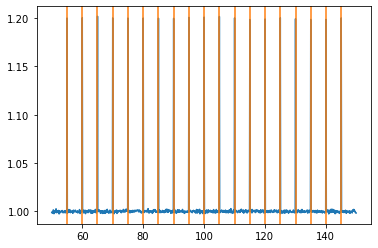

In [35]:
plt.plot(freq, sky)
for i, flg in enumerate(flags):
    if flg:
        plt.axvline(freq[i], color="C1")

In [26]:
info["model"](parameters=info["params"][10])



array([1.00187242, 1.00167595, 1.00148551, 1.00130112, 1.00112277,
       1.00095046, 1.00078419, 1.00062397, 1.00046979, 1.00032165,
       1.00017955, 1.00004349, 0.99991348, 0.9997895 , 0.99967157,
       0.99955968, 0.99945384, 0.99935403, 0.99926027, 0.99917255,
       0.99909087, 0.99901523, 0.99894564, 0.99888208, 0.99882457,
       0.9987731 , 0.99872768, 0.99868829, 0.99865495, 0.99862765,
       0.99860639, 0.99859117, 0.99858199, 0.99857886, 0.99858177,
       0.99859072, 0.99860571, 0.99862675, 0.99865382, 0.99868694,
       0.9987261 , 0.9987713 , 0.99882255, 0.99887984, 0.99894316,
       0.99901253, 0.99908795, 0.9991694 , 0.9992569 , 0.99935043,
       0.99945002, 0.99955564, 0.9996673 , 0.99978501, 0.99990876,
       1.00003855, 1.00017438, 1.00031625, 1.00046417, 1.00061813,
       1.00077813, 1.00094417, 1.00111625, 1.00129438, 1.00147855,
       1.00166875, 1.00186501, 1.0020673 , 1.00227564, 1.00249001,
       1.00271043, 1.0029369 , 1.0031694 , 1.00340794, 1.00365

## Flat Sky, Random RFI, sweep

In [36]:
def rfi_random_1d():
    a = np.zeros(NFREQ)
    np.random.seed(12345)
    a[np.random.randint(0, len(a), 40)] = 1
    return a



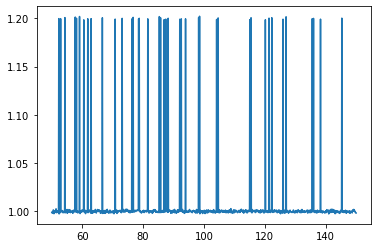

In [38]:
scale = 1000
std = uniform_sky / scale
amp = std.max() * 200
noise = thermal_noise(uniform_sky, scale=scale, seed=1010)
rfi = rfi_random_1d() * amp
sky = uniform_sky + noise + rfi

plt.plot(freq, sky)

In [47]:
flags, info = xrfi.xrfi_model_sweep(sky, threshold=5, max_iter=10, use_median=True)

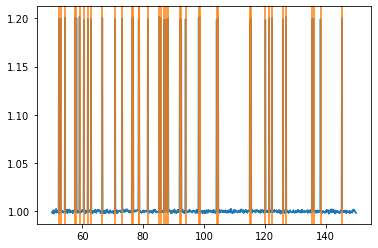

In [48]:
plt.plot(freq, sky)
for i, flg in enumerate(flags):
    if flg:
        plt.axvline(freq[i], color="C1")

In [42]:
info["params"][0]

array([  1.01298742,   0.43311315, -18.85528033])

In [43]:
info["model"](parameters=info["params"][0])

array([1.00386053, 1.00411126, 1.00435925, 1.00460451, 1.00484704,
       1.00508682, 1.00532387, 1.00555819, 1.00578977, 1.00601861,
       1.00624472, 1.00646809, 1.00668872, 1.00690662, 1.00712179,
       1.00733421, 1.0075439 , 1.00775086, 1.00795508, 1.00815656,
       1.0083553 , 1.00855131, 1.00874459, 1.00893513, 1.00912293,
       1.00930799, 1.00949032, 1.00966992, 1.00984677, 1.0100209 ,
       1.01019228, 1.01036093, 1.01052684, 1.01069002, 1.01085046,
       1.01100817, 1.01116313, 1.01131537, 1.01146486, 1.01161162,
       1.01175565, 1.01189694, 1.01203549, 1.0121713 , 1.01230438,
       1.01243473, 1.01256234, 1.01268721, 1.01280934, 1.01292874,
       1.01304541, 1.01315933, 1.01327053, 1.01337898, 1.0134847 ,
       1.01358768, 1.01368793, 1.01378544, 1.01388022, 1.01397225,
       1.01406156, 1.01414812, 1.01423195, 1.01431305, 1.01439141,
       1.01446703, 1.01453991, 1.01461006, 1.01467748, 1.01474216,
       1.0148041 , 1.0148633 , 1.01491977, 1.01497351, 1.01502

In [44]:
info["std"][0]

0.04785583904893513

In [45]:
freq[99]

59.90990990990991

In [46]:
info["iters"][0]

1